# Grade: /100 + 15 Bonus

## Instructions

- Once the notebook is complete, restart your kernel and rerun your cells

- Submit this notebook to owl by the deadline

- You may use any python library functions you wish to complete the Lab assignment.

This notebook contains the questions for Assignment 2. Make sure to complete this assignment individually and appropriately reference all external code and documentation used.


### Preliminaries

Feel free to add any libraries to the Preliminaries. However, be mindful of every question's restrictions as some may exclude use of some functions.


In [100]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, roc_curve, auc, confusion_matrix
from sklearn.ensemble import RandomForestRegressor

from scikeras.wrappers import KerasRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

## Part 1 - Multi-Layer Perceptron (MLP) for Regression (65 pts)

### Dataset

The dataset `startup_success_dataset.csv` contains information on startup companies and is designed to predict the success of these companies based on various features. Your tasks involve data preprocessing, exploratory data analysis, applying machine learning models, and evaluating their performance and fairness.


The dataset contains 1000 records and 14 columns. Here's a brief overview of the columns:

1. StartupID: A unique identifier for each startup.
2. Industry: The industry sector the startup operates in (e.g., Finance, Education, Tech).
3. Age: The age of the startup in years.
4. Location: The geographical location of the startup (e.g., Asia, North America, Europe
5. Funding: The total funding received by the startup in million USD.
6. EmployeeCount: The number of employees working in the startup.
7. ProductCount: The number of products the startup has developed.
8. Patents: The number of patents held by the startup.
9. Partnerships: The number of partnerships the startup has.
10. AnnualRevenue: The annual revenue of the startup in million USD.
11. ProfitMargin: The profit margin of the startup (could be negative).
12. MarketShare: The market share of the startup in percentage.
13. CustomerSatisfaction: The customer satisfaction rating (out of 100).
14. SuccessScore: A score representing the success of the startup (the target variable we aim to predict).

Note that `StartupID` is a unique identifier and does not contribute to predictive modeling.


### Part1 Task A - Data Loading and Preprocessing (10 pts)

Load the provided startup success dataset and prepare it for analysis. Perform necessary preprocessing steps to handle any data inconsistencies and prepare the data for machine learning models.

1. Load the dataset and remove any unnecessary columns.
2. Check for missing values and handle them appropriately (handle missing values separately for numerical and categorical columns. For numerical columns, fill missing values with the mean of their respective columns. For categorical data, if missing values exist, fill them with the mode (most frequent value).
3. Encode categorical variables using **one-hot** encoding technique. For categorical variables, we have two columns to encode:
   - Industry: With 4 unique values.
   - Location: With 3 unique values.
4. Split the dataset into features and target variables (`SuccessScore`). Display the results using **.head()** function.


In [30]:
import pandas as pd
FILE_NAME = r"startup_success_dataset.csv"
UNNECESSARY_COLUMNS = ['StartupID']
# Step 1: Load the dataset and remove unnecessary columns
# Assuming your dataset is named 'df', replace it with your dataset name
df = pd.read_csv(FILE_NAME)  # Replace 'your_dataset.csv' with your dataset file path
df.drop(UNNECESSARY_COLUMNS, axis=1, inplace=True)  # Drop unnecessary columns

In [14]:
# Step 2: Handling missing values
# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

In [15]:
numerical_cols, categorical_cols

(Index(['Age', 'Funding', 'EmployeeCount', 'ProductCount', 'Patents',
        'Partnerships', 'AnnualRevenue', 'ProfitMargin', 'MarketShare',
        'CustomerSatisfaction', 'SuccessScore'],
       dtype='object'),
 Index(['Industry', 'Location'], dtype='object'))

In [33]:
df[numerical_cols].isna().sum(), df[categorical_cols].isna().sum()

(Age                     0
 Funding                 0
 EmployeeCount           0
 ProductCount            0
 Patents                 0
 Partnerships            0
 AnnualRevenue           0
 ProfitMargin            0
 MarketShare             0
 CustomerSatisfaction    0
 SuccessScore            0
 dtype: int64,
 Industry    0
 Location    0
 dtype: int64)

In [25]:
# Fill missing values for numerical columns with mean
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())
df

,Industry,Age,Location,Funding,EmployeeCount,ProductCount,Patents,Partnerships,AnnualRevenue,ProfitMargin,MarketShare,CustomerSatisfaction,SuccessScore
0,Finance,17,Asia,188.165509,343,7,5,8,26.657424,6.514471,28.991712,71.305764,63.721391
1,Education,9,Asia,52.229703,47,8,1,3,65.216576,-11.429246,8.125782,64.377673,86.092406
2,Tech,1,North America,86.216534,376,5,14,2,77.067519,25.855096,33.709881,58.016024,65.511363
3,Finance,20,Europe,174.609685,423,7,1,3,21.948196,27.398470,6.673444,64.107779,67.447699
4,Finance,13,Europe,168.465747,492,8,1,3,64.292718,18.357728,40.292885,61.662585,71.060720
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Tech,3,Europe,76.413283,213,8,9,4,24.096291,0.494178,48.871252,91.935226,87.912455
996,Tech,6,North America,33.025550,132,7,13,3,100.003148,32.476348,14.083968,71.428231,91.394092
997,Education,9,Asia,157.348028,344,5,6,6,106.611091,13.832022,24.033506,86.329288,68.925611
998,Education,6,North America,147.021564,120,9,0,6,27.504090,10.986661,22.399773,75.503011,86.993287


In [37]:
df['Industry'].mode(), df['Location'].mode()

(0    Education
 Name: Industry, dtype: object,
 0    Europe
 Name: Location, dtype: object)

In [17]:
# Fill missing values for categorical columns with mode
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [44]:
# Step 3: One-hot encoding for categorical variables
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(df[categorical_cols])
X_encoded

<1000x7 sparse matrix of type '<class 'numpy.float64'>'
	with 2000 stored elements in Compressed Sparse Row format>

In [45]:
# Create the names for the one-hot encoded categorical features
categorical_columns = []
for i, col in enumerate(categorical_cols):
    for cat in encoder.categories_[i]:
        categorical_columns.append(f'{col}_{cat}')
categorical_columns

['Industry_Education',
 'Industry_Finance',
 'Industry_Health',
 'Industry_Tech',
 'Location_Asia',
 'Location_Europe',
 'Location_North America']

In [47]:
one_hot_features = pd.DataFrame(X_encoded.toarray(), columns=categorical_columns)
one_hot_features

,Industry_Education,Industry_Finance,Industry_Health,Industry_Tech,Location_Asia,Location_Europe,Location_North America
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,1.0,0.0,1.0,0.0
996,0.0,0.0,0.0,1.0,0.0,0.0,1.0
997,1.0,0.0,0.0,0.0,1.0,0.0,0.0
998,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [49]:
df_onehotencoded = pd.concat([df.drop(categorical_cols, axis=1), one_hot_features], axis=1)
df_onehotencoded

,Age,Funding,EmployeeCount,ProductCount,Patents,Partnerships,AnnualRevenue,ProfitMargin,MarketShare,CustomerSatisfaction,SuccessScore,Industry_Education,Industry_Finance,Industry_Health,Industry_Tech,Location_Asia,Location_Europe,Location_North America
0,17,188.165509,343,7,5,8,26.657424,6.514471,28.991712,71.305764,63.721391,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,9,52.229703,47,8,1,3,65.216576,-11.429246,8.125782,64.377673,86.092406,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,86.216534,376,5,14,2,77.067519,25.855096,33.709881,58.016024,65.511363,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,20,174.609685,423,7,1,3,21.948196,27.398470,6.673444,64.107779,67.447699,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,13,168.465747,492,8,1,3,64.292718,18.357728,40.292885,61.662585,71.060720,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,76.413283,213,8,9,4,24.096291,0.494178,48.871252,91.935226,87.912455,0.0,0.0,0.0,1.0,0.0,1.0,0.0
996,6,33.025550,132,7,13,3,100.003148,32.476348,14.083968,71.428231,91.394092,0.0,0.0,0.0,1.0,0.0,0.0,1.0
997,9,157.348028,344,5,6,6,106.611091,13.832022,24.033506,86.329288,68.925611,1.0,0.0,0.0,0.0,1.0,0.0,0.0
998,6,147.021564,120,9,0,6,27.504090,10.986661,22.399773,75.503011,86.993287,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [19]:
# Step 4: Split dataset into features and target variable
X = df.drop('SuccessScore', axis=1)  # Features
y = df['SuccessScore']  # Target variable

In [10]:
# Display the results using .head() function
X.head()

,StartupID,Age,Funding,EmployeeCount,ProductCount,Patents,Partnerships,AnnualRevenue,ProfitMargin,MarketShare,CustomerSatisfaction,Industry_Education,Industry_Finance,Industry_Health,Industry_Tech,Location_Asia,Location_Europe,Location_North America
0,1,17,188.165509,343,7,5,8,26.657424,6.514471,28.991712,71.305764,False,True,False,False,True,False,False
1,2,9,52.229703,47,8,1,3,65.216576,-11.429246,8.125782,64.377673,True,False,False,False,True,False,False
2,3,1,86.216534,376,5,14,2,77.067519,25.855096,33.709881,58.016024,False,False,False,True,False,False,True
3,4,20,174.609685,423,7,1,3,21.948196,27.398470,6.673444,64.107779,False,True,False,False,False,True,False
4,5,13,168.465747,492,8,1,3,64.292718,18.357728,40.292885,61.662585,False,True,False,False,False,True,False


In [11]:
y.head()

0    63.721391
1    86.092406
2    65.511363
3    67.447699
4    71.060720
Name: SuccessScore, dtype: float64

### Part1 Task B - Exploratory Data Analysis (EDA) (10 pts)

1. Visualize the distribution of key features and the target variable. Your solution must focuse on visualizing the distribution of the target variable ('SuccessScore') with a histogram with kernel density estimate (KDE) overlays.
2. Generate a heatmap of the correlation matrix to identify strongly correlated features.


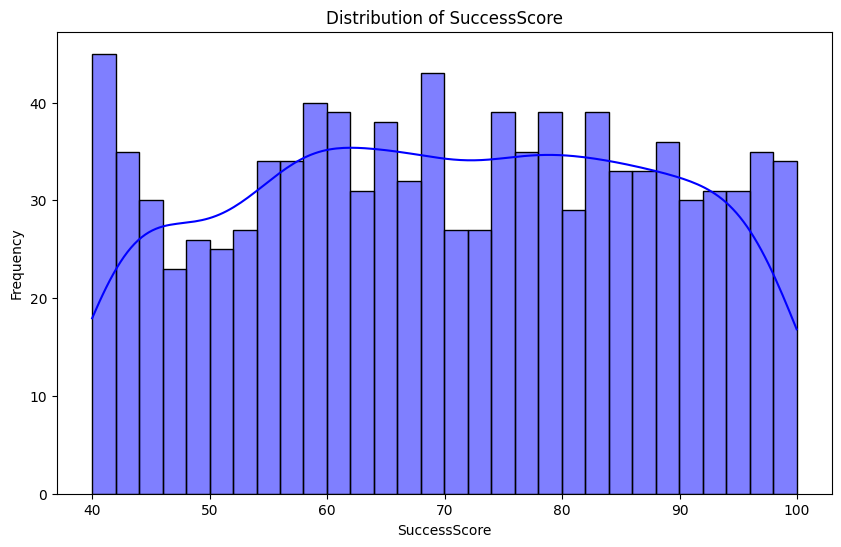

In [53]:
plt.figure(figsize=(10, 6))
sns.histplot(df_onehotencoded['SuccessScore'], kde=True, color='blue', bins=30)
plt.title('Distribution of SuccessScore')
plt.xlabel('SuccessScore')
plt.ylabel('Frequency')
plt.show()

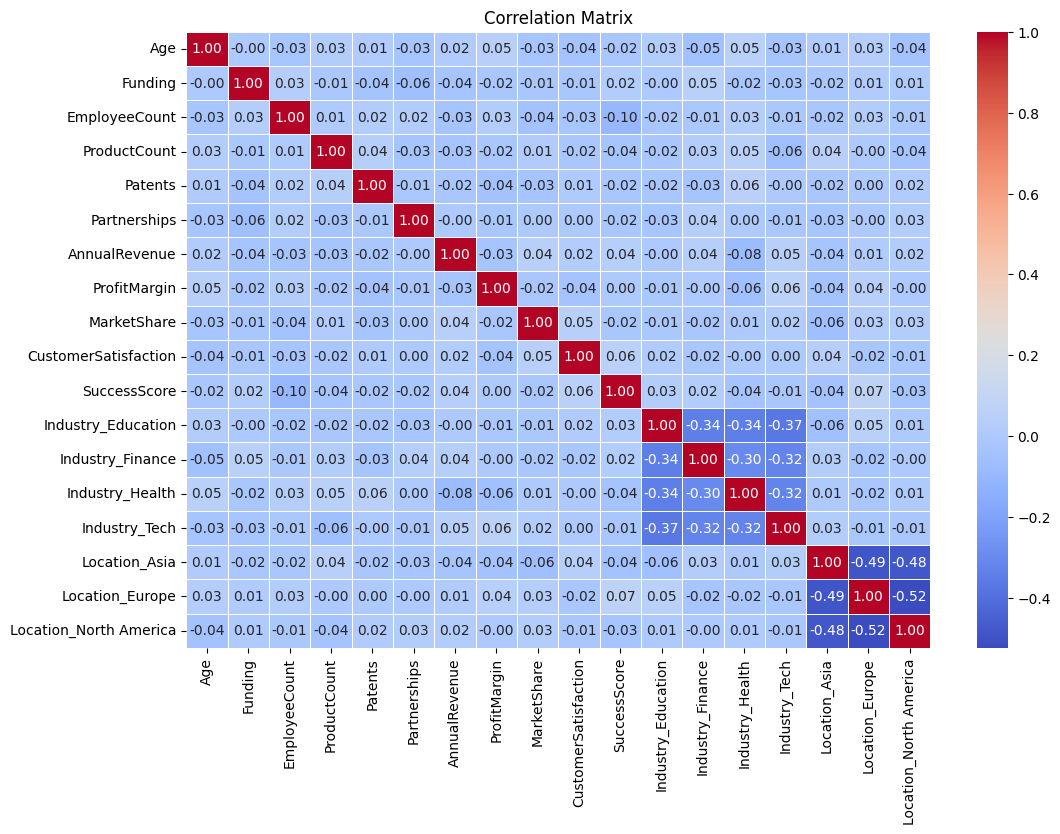

In [52]:
# 2. Generate a heatmap of the correlation matrix
correlation_matrix = df_onehotencoded.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Part1 Task C - Feature Engineering and PCA (10 pts)

1. Split the data into training and testing sets with 8:2 ratio and standardize the feature set. You need to use `StandardScaler` to ensure that each feature has a mean of 0 and a standard deviation of 1. This standardization is applied to both the training and testing sets to ensure consistency. Use `random_state` = 42 to ensure that the split is reproducible and fixed with every code iteration, allowing for consistent training and evaluation.
2. Plot the explained variance ratio of the principal components and determine visually the number of components to retain 80% of variance.
3. Apply PCA using the number found in the previous step to reduce the feature size.


In [54]:
# Step 1: Split the data into training and testing sets with 8:2 ratio and standardize the feature set
X = df_onehotencoded.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
X_train

,Age,Funding,EmployeeCount,ProductCount,Patents,Partnerships,AnnualRevenue,ProfitMargin,MarketShare,CustomerSatisfaction,SuccessScore,Industry_Education,Industry_Finance,Industry_Health,Industry_Tech,Location_Asia,Location_Europe,Location_North America
29,9,54.753970,17,8,7,3,131.477084,16.643907,42.020017,63.051433,85.325866,1.0,0.0,0.0,0.0,1.0,0.0,0.0
535,13,12.960290,324,3,4,8,125.495493,-18.215824,44.285096,53.830538,69.806207,0.0,0.0,1.0,0.0,0.0,1.0,0.0
695,16,129.144104,405,5,5,3,12.254457,29.053920,24.860120,99.974818,99.398837,1.0,0.0,0.0,0.0,0.0,1.0,0.0
557,6,59.276570,21,4,3,3,44.775376,33.747572,41.509628,81.496025,86.950720,0.0,0.0,1.0,0.0,1.0,0.0,0.0
836,14,128.302729,167,2,9,4,146.240707,4.725794,49.965813,67.621797,56.292686,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,16,13.508316,219,6,11,9,42.294508,-0.140483,42.122849,56.308480,87.398486,0.0,0.0,1.0,0.0,0.0,1.0,0.0
270,17,104.528415,172,8,11,9,40.668494,20.553557,33.700368,55.917705,43.238186,0.0,0.0,1.0,0.0,0.0,1.0,0.0
860,17,183.946439,360,2,5,6,135.384526,24.091031,20.135582,59.367521,43.402279,1.0,0.0,0.0,0.0,0.0,0.0,1.0
435,20,137.810710,39,7,14,0,24.771454,1.383430,32.967515,81.091228,65.463778,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [70]:
X_test

,Age,Funding,EmployeeCount,ProductCount,Patents,Partnerships,AnnualRevenue,ProfitMargin,MarketShare,CustomerSatisfaction,SuccessScore,Industry_Education,Industry_Finance,Industry_Health,Industry_Tech,Location_Asia,Location_Europe,Location_North America
521,3,115.667166,417,4,12,2,132.540651,27.140149,10.508792,62.740163,56.263779,0.0,1.0,0.0,0.0,0.0,0.0,1.0
737,10,69.945071,400,3,11,1,113.311462,31.231960,33.855318,82.275574,94.620781,0.0,0.0,0.0,1.0,1.0,0.0,0.0
740,9,60.310205,283,3,13,5,112.692528,-19.519512,7.782400,68.681733,97.513920,0.0,1.0,0.0,0.0,0.0,0.0,1.0
660,17,133.443890,163,5,14,1,137.893348,21.378311,40.360550,76.325972,77.570767,1.0,0.0,0.0,0.0,0.0,1.0,0.0
411,20,74.548898,348,5,7,9,27.057706,-1.628245,12.080123,89.225280,68.815240,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,20,86.481551,323,3,12,8,5.093114,33.472048,15.271638,75.408190,93.291397,1.0,0.0,0.0,0.0,0.0,1.0,0.0
332,1,123.604770,141,2,8,0,16.833620,-19.195433,6.494940,63.311675,99.422466,1.0,0.0,0.0,0.0,0.0,0.0,1.0
208,3,61.137307,409,3,10,6,41.059680,-11.179103,49.594643,91.268899,48.087870,0.0,0.0,1.0,0.0,0.0,0.0,1.0
613,19,48.765370,189,2,5,2,2.507050,-19.188964,41.706933,61.420448,57.080464,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [56]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

In [68]:
scaler.mean_

array([1.02087500e+01, 1.00207726e+02, 2.58595000e+02, 5.13125000e+00,
       6.83125000e+00, 4.57625000e+00, 7.42114221e+01, 1.07409612e+01,
       2.52493069e+01, 7.41158946e+01, 6.97390047e+01, 2.82500000e-01,
       2.36250000e-01, 2.23750000e-01, 2.57500000e-01, 3.16250000e-01,
       3.37500000e-01, 3.46250000e-01])

In [64]:
X_train_scaled.mean(axis = 0), X_train_scaled.std(axis = 0)

(array([-4.88498131e-17,  5.10702591e-17, -1.92623695e-16,  1.57651669e-16,
         5.38458167e-17,  2.99760217e-17,  5.77315973e-17, -7.66053887e-17,
        -1.68753900e-16, -1.46549439e-16,  5.77315973e-17,  6.27276009e-17,
         1.11299858e-16, -5.99520433e-17, -4.88498131e-17,  1.46549439e-16,
        -4.44089210e-17, -2.55351296e-17]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1.]))

In [65]:
X_test_scaled.mean(axis = 0), X_test_scaled.std(axis = 0)

(array([ 0.10811375,  0.03372729, -0.12985782, -0.05283936,  0.00890504,
        -0.02334037,  0.04326283, -0.04747014,  0.08952248,  0.10794505,
         0.13236814, -0.0277645 , -0.05002619,  0.07498384,  0.00571746,
        -0.03494535,  0.11102722, -0.07619163]),
 array([1.07697257, 0.91062403, 1.02642739, 0.91649834, 0.99650375,
        1.0149817 , 0.94589263, 1.03608847, 1.03992276, 0.89807623,
        0.98385484, 0.98610494, 0.96714711, 1.04584156, 1.00314956,
        0.98547523, 1.03149563, 0.97208591]))

In [58]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

In [71]:
pca.explained_variance_ratio_

array([0.08972757, 0.0863351 , 0.07919326, 0.07491636, 0.07424228,
       0.06674447, 0.06111337, 0.05985368, 0.05790344, 0.05666384,
       0.05439212, 0.05198988])

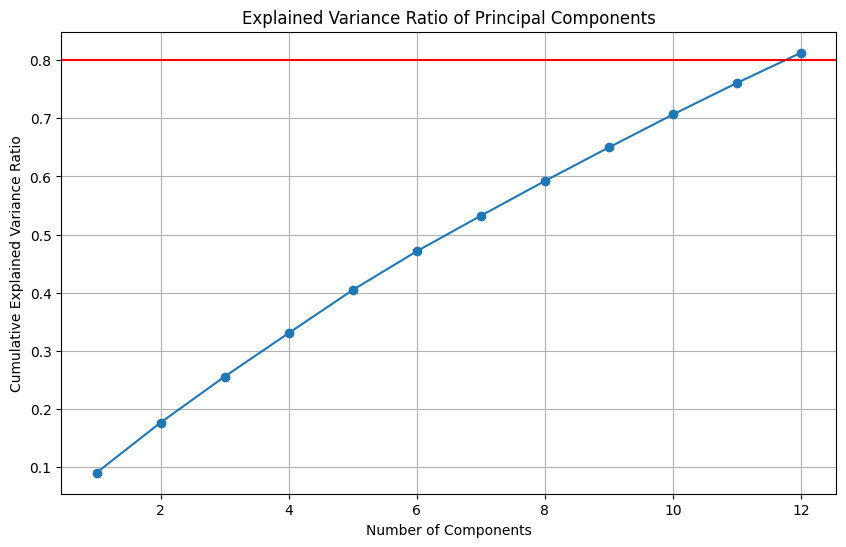

In [107]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='-')
plt.title('Explained Variance Ratio of Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.axhline(y=0.8, color='r')
plt.grid(True)
plt.show()

In [60]:
# Step 3: Determine visually the number of components to retain 80% of variance
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()
num_components_80_variance = len(cumulative_variance_ratio[cumulative_variance_ratio <= 0.8]) + 1
print(f"Number of components to retain 80% of variance: {num_components_80_variance}")

Number of components to retain 80% of variance: 12


In [61]:
# Step 4: Apply PCA using the number found in the previous step to reduce the feature size
pca = PCA(n_components=num_components_80_variance)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [72]:
X_train_pca

array([[ 0.13323047, -0.80149115, -0.15616393, ...,  1.42843688,
         0.39745283, -0.84662275],
       [ 0.70947041, -0.4036628 ,  1.39640724, ..., -0.1396352 ,
        -1.52160154, -0.75292134],
       [ 2.59475699, -0.88633908,  0.68701684, ...,  0.28355154,
         0.6448342 ,  1.42745918],
       ...,
       [ 0.55026537,  1.98524151,  0.51704708, ..., -0.17109964,
        -1.90503784,  0.29796705],
       [ 0.30006443,  1.24151703,  1.2623746 , ...,  0.76153702,
         0.09878556, -0.35601494],
       [ 0.76475878, -0.76347889,  1.38299642, ..., -1.66909255,
         1.83798138, -0.72289082]])

In [73]:
X_test_pca

array([[-0.75076957,  1.91197637, -0.34382615, ..., -0.10217404,
        -0.57782785,  0.8852089 ],
       [-0.59967959, -1.2278748 , -2.2670977 , ...,  0.49903842,
        -0.6500432 ,  1.58357338],
       [-0.52684142,  1.68451147, -0.09305561, ..., -1.92399213,
        -0.95579469,  0.30227803],
       ...,
       [-1.31843314,  1.88292913,  1.1038875 , ..., -0.13499049,
        -0.1488898 ,  0.55029485],
       [-1.29989852,  1.19246272,  1.70212333, ...,  0.12737993,
        -0.53379077, -0.59215651],
       [-1.52489243, -0.71682676, -0.87682891, ...,  2.02573712,
        -0.07170849, -0.31555677]])

### Part1 Task D - MLP for Regression (15 pts)

1. Using **TensorFlow's Keras API**, develop and train two MLP regressors over 100 epochs with a batch size of 32:

   - For Model 1, incorporate a single hidden layer containing 32 neurons.
   - Model 2 should feature two hidden layers, with the first layer comprising 32 neurons and the second layer 16 neurons.
   - Additionally, implement a Random Forest Regressor as the traditional regression algorithm to compare its performance against the ANN models.
   - Incorporate L2 regularization in models, use Adam optimizer with a learning rate of **0.01** and **Relu** activation function in hidden layers.

2. Evaluate the model's performance on the test set using Mean Squared Error (MSE) and Mean Absolute Error (MAE) metrics.
3. **(Written Answer)** Compare the models and write your conclusion.

Note:

- You might need to create a new optimizer instance for each model. This ensures that each model's training process is independent and avoids conflicts arising from shared optimizer state.
- You can choose between the **Sequential model** from TensorFlow's Keras API and the **MLPRegressor** from scikit-learn for your solution. The former provides a highly flexible and customizable framework for constructing neural networks, allowing for detailed adjustments to model architecture and training procedures. On the other hand, the latter, built on scikit-learn, offers a more direct method for developing multilayer perceptron models tailored specifically to regression tasks, with less complexity in customization but efficiency in straightforward applications.


**Place holder for Written Answer**


In [86]:
X_train_pca.shape[1]

12

In [87]:
# Define the MLP models
def create_model1(input_shape):
    model = Sequential([
        Dense(32, activation='relu', kernel_regularizer=l2(0.01), input_shape=(input_shape, )),
        Dense(1)
    ])
    return model

def create_model2(input_shape):
    model = Sequential([
        Dense(32, activation='relu', kernel_regularizer=l2(0.01), input_shape=(input_shape, )),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(1)
    ])
    return model

# Create MLP models
model1 = create_model1(X_train_pca.shape[1])
model2 = create_model2(X_train_pca.shape[1])

In [92]:
# Compile MLP models
optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.01)
model1.compile(optimizer=optimizer1, loss='mse', metrics=['mae'])
optimizer2 = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
model2.compile(optimizer=optimizer2, loss='mse', metrics=['mae'])

In [90]:
# Train MLP models
history1 = model1.fit(X_train_pca, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

In [93]:
history2 = model2.fit(X_train_pca, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

In [94]:
# Train Random Forest Regressor
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train_pca, y_train)

RandomForestRegressor()

In [95]:
# Evaluate models on test set
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return mse, mae

In [96]:
# Evaluate MLP models
mse_model1, mae_model1 = evaluate_model(model1, X_test_pca, y_test)
mse_model2, mae_model2 = evaluate_model(model2, X_test_pca, y_test)

# Evaluate Random Forest Regressor
mse_rf, mae_rf = evaluate_model(rf_regressor, X_test_pca, y_test)

print("MLP Model 1 - MSE:", mse_model1, "MAE:", mae_model1)
print("MLP Model 2 - MSE:", mse_model2, "MAE:", mae_model2)
print("Random Forest Regressor - MSE:", mse_rf, "MAE:", mae_rf)

7/7 [==============================] - 0s 460us/step
MLP Model 1 - MSE: 52.4182078381616 MAE: 5.44781393023877
MLP Model 2 - MSE: 148.04714029753373 MAE: 9.415219413325147
Random Forest Regressor - MSE: 163.90061576428656 MAE: 10.406803999516


### Part1 Task E - Gridsearch for Hyperparameter Optimization (HPO) (20 pts)

1. Define a range of potential values for hyperparameters as follows:
   - `hidden_layer_sizes`:50, 100, 150
   - `activation`: tanh','relu'
   - `learning rate`: 0.0001, 0.001, 0.01
2. Use GridSearchCV to find the best hyperparameter values based on 3 fold cross-validation on MLP model2 from TaskD.
3. Retrain the model using the optimized hyperparameters and evaluate its performance.
4. **(Written Answer)** Comparing the performance of MLP model2 before (from TaskD) and after hyperparameter tuning.


In [98]:
# Define a range of potential values for hyperparameters
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,)],
    'activation': ['tanh', 'relu'],
    'learning_rate_init': [0.0001, 0.001, 0.01]
}

In [ ]:
def create_model(hidden_layer_sizes=100, activation='relu', learning_rate=0.01):
    model = Sequential([
        Dense(32, input_shape=(X_train_pca.shape[1],), activation=activation, kernel_regularizer=l2(0.01)),
        Dense(16), activation=activation, kernel_regularizer=l2(0.01)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model


In [104]:
model_grid = 
# Use GridSearchCV to find the best hyperparameters
keras_reg = KerasRegressor(model = model2, epochs=100, verbose=0)
grid_search = GridSearchCV(keras_reg, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_pca, y_train)

INFO:tensorflow:Assets written to: ram://6e2bbeeaead34afea758db96e3fbccf1/assets


INFO:tensorflow:Assets written to: ram://6e2bbeeaead34afea758db96e3fbccf1/assets
2024-03-25 16:13:46.772693: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://cf7ab43867924b6eba3d987ff4eac98f: INVALID_ARGUMENT: ram://cf7ab43867924b6eba3d987ff4eac98f is a directory.


AttributeError: 'Adam' object has no attribute 'build'

In [ ]:
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

**Place holder for Written Answer**


## Part 2 - Binary Classification with a Custom MLP (35 pts)

### Background

You are provided with a schematic of a simple Multilayer Perceptron (MLP) neural network designed for binary classification. This network consists of an input layer with two binary inputs, $x_1$ and $x_2$, a hidden layer with two neurons, $h_1$ and $h_2$, and one output neuron, $y$. The weights and biases are pre-defined as follows:

- Weights from the input to hidden layer: $w_{11} = 20, w_{12} = -20, w_{21} = 20, w_{22} = -20$
- Biases for the hidden layer neurons: $b_{1} = -10, b_{2} = 30$
- Weights from the hidden layer to the output layer are both $20$.
- The bias for the output neuron is $-30$.

!["The simple Multilayer Perceptron (MLP) neural network"](./NNQ.png)

P.S. For the image to display correctly, it must be located in the same folder as your Assignment #2 file: `Assignment2.ipynb`.

### Objective

Implement a Python program that simulates the described MLP network's forward pass and computes the output for different input combinations.


### Part2 Task A - Sigmoid Activation Function (20 pts)

Write a function that takes binary inputs $x_1$ and $x_2$ and computes the output $y$ using a sigmoid activation function for both the hidden and output layers.
Calculate and print the predicted output for the following input pairs: (0,0), (0,1), (1,0), (1,1). Round the output to the nearest integer.


### Part2 Task B - Linear Activation Function (10 pts)

Modify the function from TaskA to use a linear activation function instead of the sigmoid.
Calculate and print the predicted output for the same input pairs as above.


### Part2 TaskC - Hidden Neuron operation (3 pts)

Analyze the function of the hidden neuron $h_{1}$ when using a sigmoid activation function. Discuss which logical problem (\(e.g., AND, OR, XOR\)) $h_{1}$ is solving.


**Placeholder for Task C answer**


### Part2 Task D - MLP operation (2 pts)

Consider the entire network with a sigmoid activation function. Discuss which logical problem the MLP is designed to solve considering the weights and biases configuration.


**Placeholder for Task D answer**


## Part 3 - Convolutional Neural Network (CNN) - (15 Bonus pts)

### Objective:

Develop a Convolutional Neural Network (CNN) model to classify handwritten digits from the MNIST dataset. Your tasks involve loading and preprocessing the dataset, designing a CNN architecture, training the model while reserving a portion of the data for validation, and evaluating the model's performance. Additionally, assess if the model exhibits overfitting through the analysis of learning curves.


### Part3 TaskA - Image Classification (20 pts)

1. Load the MNIST Dataset which consists of grayscale images of handwritten digits. Normalize the image pixel values to a range of [0, 1], reshape the images to fit the CNN input requirements and convert the labels to one-hot encoded vectors for classification.
2. Design a CNN architecture for classifying MNIST handwritten digits with input layer of 28x28 pixel grayscale images, followed by three convolutional layers with ReLU activation (the first with 32 filters of size 3x3, the second with 64 filters of size 3x3 plus a max pooling layer of size 2x2, and the third also with 64 filters of size 3x3 followed by another max pooling layer of size 2x2). After these, a flatten layer transitions the output to a 1D vector, leading to a dense layer with 64 units (ReLU activation), and culminating in an output layer with 10 units for the 10 digit classes (0-9) using softmax activation.
3. Keep 20% of MNIST training dataset for validation and train the CNN on the remaining part of MNIST training dataset.
4. Plot the learning curves.
5. **(Written Answer)** Explain whether the model overfits or not.
6. Evaluate the model's accuracy and F1-score on the MNIST test dataset.


**Place holder for Written Answer**
